In [ ]:
# Copyright © 2025 Amlan Chatterjee. All rights reserved.

"""
RADAR FUNDAMENTALS & SIMULATOR - Part 1
========================================
A hands-on guide to understanding radar signal processing from first principles

Target: Build intuition through concepts, formulas, and code
Timeline: Weekend 1 (Oct 5-6)

Author: Learning Path for Applied AI Role
Date: Oct 2025
"""
#
""" Check for GPU support """
#

import torch
if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print("GPU Connected \n"  + gpu_info)
elif torch.backends.mps.is_available():
    print("MPS (Apple Metal) is available")
    device = torch.device("mps")
else:
    print("No GPU available")


MPS (Apple Metal) is available


# Part 1: Radar Fundamentals Refresher

## Overview
This notebook bridges your existing RF/DSP knowledge to radar-specific processing.
We'll cover:
1. FMCW vs Pulse-Doppler (conceptual comparison)
2. I/Q Fundamentals (quick review)
3. Range Processing (Range-FFT)
4. Doppler Processing (Doppler-FFT)
5. Range-Doppler Maps (RDM)

**Learning approach:** Concept → Formula → Code → Experiment

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftshift, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

---
# 1. FMCW vs Pulse-Doppler: Quick Comparison

## FMCW Radar

**Concept:**
- Transmit continuous chirp: frequency sweeps from f₀ to f₀ + B over time T_chirp
- Receive echo from target (delayed by 2R/c)
- Mix TX and RX → "dechirp" → constant beat frequency f_beat

**Key Formula (you nailed this!):**
```
Beat frequency:    f_beat = (2 * R * B) / (c * T_chirp)
Range extraction:  R = (c * T_chirp * f_beat) / (2 * B)
```
Where:
- R = range to target (meters)
- B = bandwidth (Hz)
- c = speed of light (3e8 m/s)
- T_chirp = chirp duration (seconds)

**Processing:** FFT of beat signal → peaks at f_beat → convert to range

---

## Pulse-Doppler Radar (What you'll actually use)

**Concept:**
- Transmit SHORT pulses (not continuous)
- Listen for echoes during "quiet time" between pulses
- Coherently process multiple pulses to extract BOTH range AND velocity

**Key Difference:**
- FMCW: ONE chirp gives you range
- Pulse-Doppler: MULTIPLE pulses give you range + velocity simultaneously

**Why Pulse-Doppler for counter-UAS?**
- Better Doppler resolution (distinguishes hovering vs moving targets)
- Micro-Doppler signatures from rotors/wings
- Lower probability of intercept (LPI) - pulses vs continuous

**Processing Architecture:**
```
Time domain signal (I/Q samples)
    ↓
[Range-FFT] ← FFT across "fast time" (within each pulse)
    ↓
Range bins (like your beat frequency, but discrete bins)
    ↓
[Doppler-FFT] ← FFT across "slow time" (pulse to pulse)
    ↓
Range-Doppler Map (RDM) - 2D image: range vs velocity
```

---
# 2. I/Q Fundamentals (Quick Review)

## Complex Baseband Representation

**Concept:**
Real RF signal at carrier f_c can be represented as complex baseband:

```
s_RF(t) = A(t) * cos(2π f_c t + φ(t))

Complex baseband:
s(t) = I(t) + j*Q(t) = A(t) * exp(j*φ(t))

Where:
 -   I(t) = A(t) * cos(φ(t)) = In-phase component
 -   Q(t) = A(t) * sin(φ(t)) = Quadrature component

```

**Why I/Q?**
- Preserves amplitude AND phase information
- Allows negative frequencies (Doppler can be positive or negative!)
- Simplifies signal processing (baseband instead of RF)


**Key Properties:**
```
Magnitude:  |s(t)| = sqrt(I² + Q²) = A(t)
Phase:      ∠s(t) = arctan(Q/I) = φ(t)
Frequency:  f = (1/2π) * dφ/dt  (instantaneous frequency)
```

Signal frequency: 100 Hz
Magnitude (should be constant): 1.000
Phase slope (should be 2π*f): -10.0 Hz


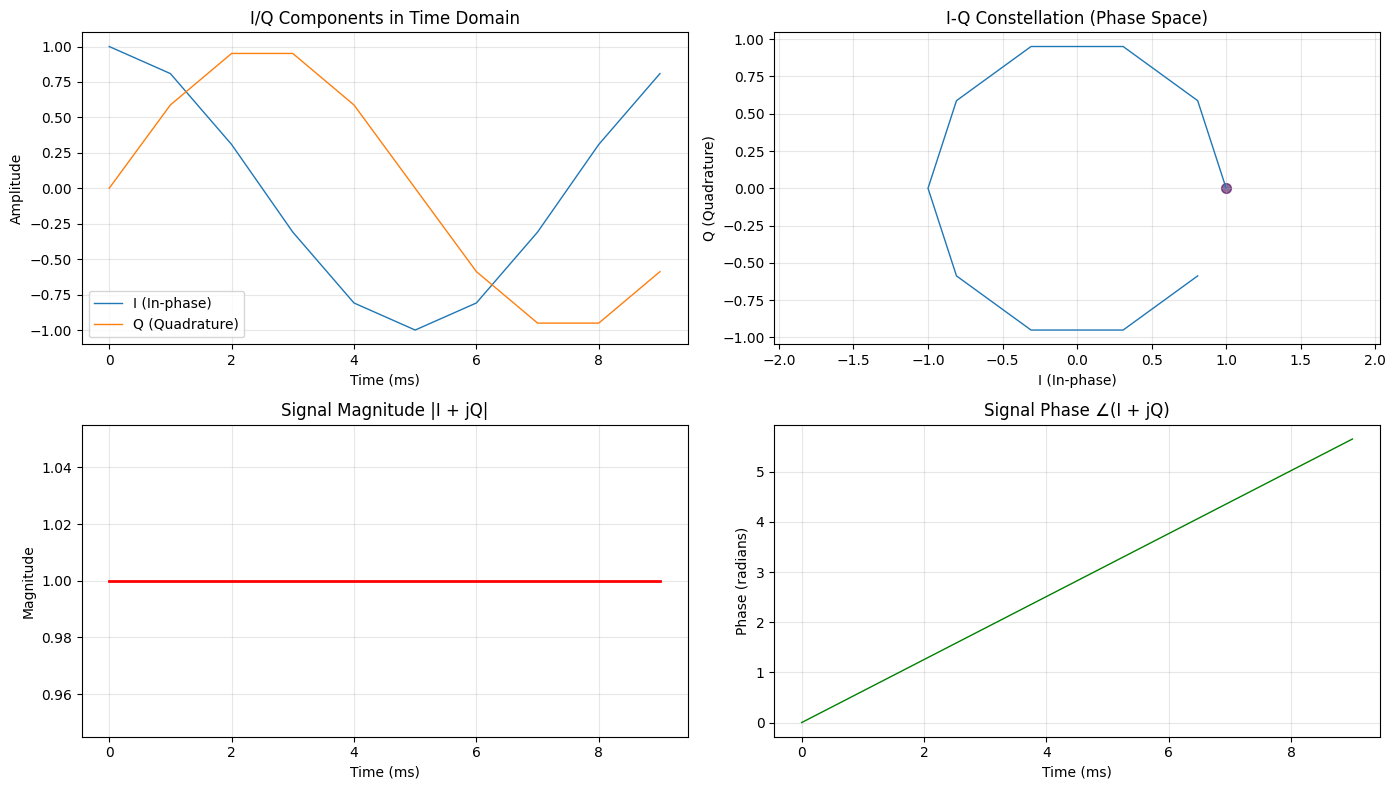

In [3]:
# Quick I/Q visualization
def visualize_iq_signal():
    """Demonstrate I/Q representation of a simple tone"""

    # Parameters
    fs = 1000  # Sampling rate frequency(Hz)
    duration = 0.01  # 10 ms
    signal_fc = 100  # Carrier Signal frequency (Hz)

    t = np.arange(0, duration, 1/fs)

    # Complex baseband signal (tone at signal_fc)
    # IQ = e^(1j * 2 * pi * signal_fc * t)
    #
    signal_iq = np.exp(1j * 2 * np.pi * signal_fc * t)

    I = signal_iq.real # In phase
    Q = signal_iq.imag # Quadrature

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # I and Q components
    axes[0, 0].plot(t * 1000, I, label='I (In-phase)', linewidth=1)
    axes[0, 0].plot(t * 1000, Q, label='Q (Quadrature)', linewidth=1)
    axes[0, 0].set_xlabel('Time (ms)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].set_title('I/Q Components in Time Domain')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # I-Q constellation (phase space)
    axes[0, 1].plot(I, Q, linewidth=1)
    axes[0, 1].scatter(I[::10], Q[::10], c=t[::10], cmap='viridis', s=50, alpha=0.6)
    axes[0, 1].set_xlabel('I (In-phase)')
    axes[0, 1].set_ylabel('Q (Quadrature)')
    axes[0, 1].set_title('I-Q Constellation (Phase Space)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axis('equal')

    # Magnitude
    magnitude = np.abs(signal_iq)
    axes[1, 0].plot(t * 1000, magnitude, linewidth=2, color='red')
    axes[1, 0].set_xlabel('Time (ms)')
    axes[1, 0].set_ylabel('Magnitude')
    axes[1, 0].set_title('Signal Magnitude |I + jQ|')
    axes[1, 0].grid(True, alpha=0.3)

    # Phase
    phase = np.angle(signal_iq)
    axes[1, 1].plot(t * 1000, np.unwrap(phase), linewidth=1, color='green')
    axes[1, 1].set_xlabel('Time (ms)')
    axes[1, 1].set_ylabel('Phase (radians)')
    axes[1, 1].set_title('Signal Phase ∠(I + jQ)')
    axes[1, 1].grid(True, alpha=0.3)

    print(f"Signal frequency: {signal_fc} Hz")
    print(f"Magnitude (should be constant): {magnitude[0]:.3f}")
    print(f"Phase slope (should be 2π*f): {(phase[-1] - phase[0]) / duration / (2*np.pi):.1f} Hz")

    plt.tight_layout()
    # plt.savefig('/Users/amlanchatterjee/Documents/iq_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Uncomment to run:
visualize_iq_signal()

---
# 3. Pulse-Doppler Radar: The Radar Equation

## Basic Radar Range Equation

**Power received from a target:**
```
P_r = (P_t * G² * λ² * σ) / ((4π)³ * R⁴)

Where:
- P_t = Transmitted power (Watts)
- G = Antenna gain (dimensionless)
- λ = Wavelength (meters) = c / f_c
- σ = Radar Cross Section (m²) - target "size" to radar
- R = Range to target (meters)
```

**Note the R⁴ term!** This is why radar is hard - signal falls off VERY fast.

## Pulse-Doppler Specific Parameters

### Time Domain Structure
```
PRI (Pulse Repetition Interval) = 1 / PRF
PRF (Pulse Repetition Frequency) = how often we transmit

Each pulse has:
- Pulse width (τ) = duration of transmission
- Bandwidth (B) = ~1/τ for simple pulses
```

### Range Resolution
```
ΔR = c / (2 * B)

For B = 100 MHz:
ΔR = 3e8 / (2 * 1e8) = 1.5 meters
```

### Maximum Unambiguous Range
```
R_max = c * PRI / 2 = c / (2 * PRF)

For PRF = 10 kHz:
R_max = 3e8 / (2 * 1e4) = 15 km
```

### Doppler Frequency from Moving Target
```
f_doppler = 2 * v_radial * f_c / c

Where v_radial = velocity toward/away from radar (m/s)

Example: Target at 50 m/s, f_c = 10 GHz
f_doppler = 2 * 50 * 1e10 / 3e8 = 3,333 Hz
```

### Maximum Unambiguous Velocity
```
v_max = λ * PRF / 4

For λ = 3 cm (10 GHz), PRF = 10 kHz:
v_max = 0.03 * 1e4 / 4 = 75 m/s
```

In [4]:
# Radar parameter calculator
class RadarParams:
    """Calculate and display all radar system parameters"""

    def __init__(self, f_c, PRF, bandwidth, pulse_width):
        """
        Parameters:
        - f_c: Carrier frequency (Hz)
        - PRF: Pulse Repetition Frequency (Hz)
        - bandwidth: Signal bandwidth (Hz)
        - pulse_width: Pulse duration (seconds)
        """
        self.f_c = f_c
        self.PRF = PRF
        self.B = bandwidth
        self.tau = pulse_width
        self.c = 3e8  # Speed of light
        self.wavelength = self.c / self.f_c
        self.PRI = 1 / self.PRF

    def range_resolution(self):
        """Minimum resolvable range difference"""
        return self.c / (2 * self.B)

    def max_unambiguous_range(self):
        """Maximum range before range folding occurs"""
        return self.c * self.PRI / 2

    def max_unambiguous_velocity(self):
        """Maximum velocity before Doppler folding occurs"""
        return self.wavelength * self.PRF / 4

    def doppler_frequency(self, velocity):
        """Doppler shift for given radial velocity"""
        return 2 * velocity * self.f_c / self.c

    def print_summary(self):
        """Print all key parameters"""
        print("=" * 60)
        print("RADAR SYSTEM PARAMETERS")
        print("=" * 60)
        print(f"\nSystem Configuration:")
        print(f"  Carrier Frequency:    {self.f_c/1e9:.2f} GHz")
        print(f"  Wavelength:           {self.wavelength*100:.2f} cm")
        print(f"  PRF:                  {self.PRF/1e3:.2f} kHz")
        print(f"  PRI:                  {self.PRI*1e6:.2f} μs")
        print(f"  Bandwidth:            {self.B/1e6:.2f} MHz")
        print(f"  Pulse Width:          {self.tau*1e6:.2f} μs")

        print(f"\nPerformance Limits:")
        print(f"  Range Resolution:         {self.range_resolution():.2f} m")
        print(f"  Max Unambiguous Range:    {self.max_unambiguous_range()/1e3:.2f} km")
        print(f"  Max Unambiguous Velocity: {self.max_unambiguous_velocity():.2f} m/s")

        print(f"\nExample Doppler Frequencies:")
        for v in [10, 50, 100, 200]:
            f_d = self.doppler_frequency(v)
            print(f"  {v:3d} m/s → {f_d:8.1f} Hz")
        print("=" * 60)

# Example: Typical X-band counter-UAS radar
radar = RadarParams(
    f_c=10e9,        # 10 GHz (X-band)
    PRF=10e3,        # 10 kHz
    bandwidth=150e6, # 150 MHz
    pulse_width=1e-6 # 1 μs
)

# Uncomment to see parameters:
radar.print_summary()

RADAR SYSTEM PARAMETERS

System Configuration:
  Carrier Frequency:    10.00 GHz
  Wavelength:           3.00 cm
  PRF:                  10.00 kHz
  PRI:                  100.00 μs
  Bandwidth:            150.00 MHz
  Pulse Width:          1.00 μs

Performance Limits:
  Range Resolution:         1.00 m
  Max Unambiguous Range:    15.00 km
  Max Unambiguous Velocity: 75.00 m/s

Example Doppler Frequencies:
   10 m/s →    666.7 Hz
   50 m/s →   3333.3 Hz
  100 m/s →   6666.7 Hz
  200 m/s →  13333.3 Hz


---
# 4. Range Processing: The Range-FFT

## Concept: From Time to Range

**What happens when we transmit a pulse:**
1. Pulse travels at speed of light
2. Reflects off target at range R
3. Echo returns after time delay: t_delay = 2R/c
4. We sample the received signal during "listening window"

**Key insight:**
- Different ranges → Different time delays → Different positions in sample buffer
- FFT converts time samples → frequency bins
- For pulsed radar, frequency ≈ range (baseband processing)

## The Math

**Received signal from target at range R:**
```
s_rx(t) = A * rect((t - 2R/c) / τ) * exp(j * 2π * f_c * (t - 2R/c))

After mixing down to baseband (removing f_c):
s_baseband(t) = A * rect((t - 2R/c) / τ) * exp(-j * 4π * R / λ)
                                             ^^^^^^^^^^^^^^^^^^^^
                                             Phase delay from range
```

**For a simple pulse (no chirp), the range information is in:**
- Time delay (when the echo arrives)
- Phase shift (∝ range)

**Range-FFT Process:**
```
1. Sample received signal at rate f_s (fast enough to capture bandwidth)
2. Take N samples during listening window
3. FFT of N samples → N frequency bins
4. Each bin corresponds to a range:

   Range of bin k = (k * c) / (2 * f_s)

5. Magnitude of each bin = signal strength at that range
```

## Range Bin Spacing
```
Δ_range_bin = c / (2 * f_s)

Example: f_s = 200 MHz
Δ_range_bin = 3e8 / (2 * 2e8) = 0.75 m
```

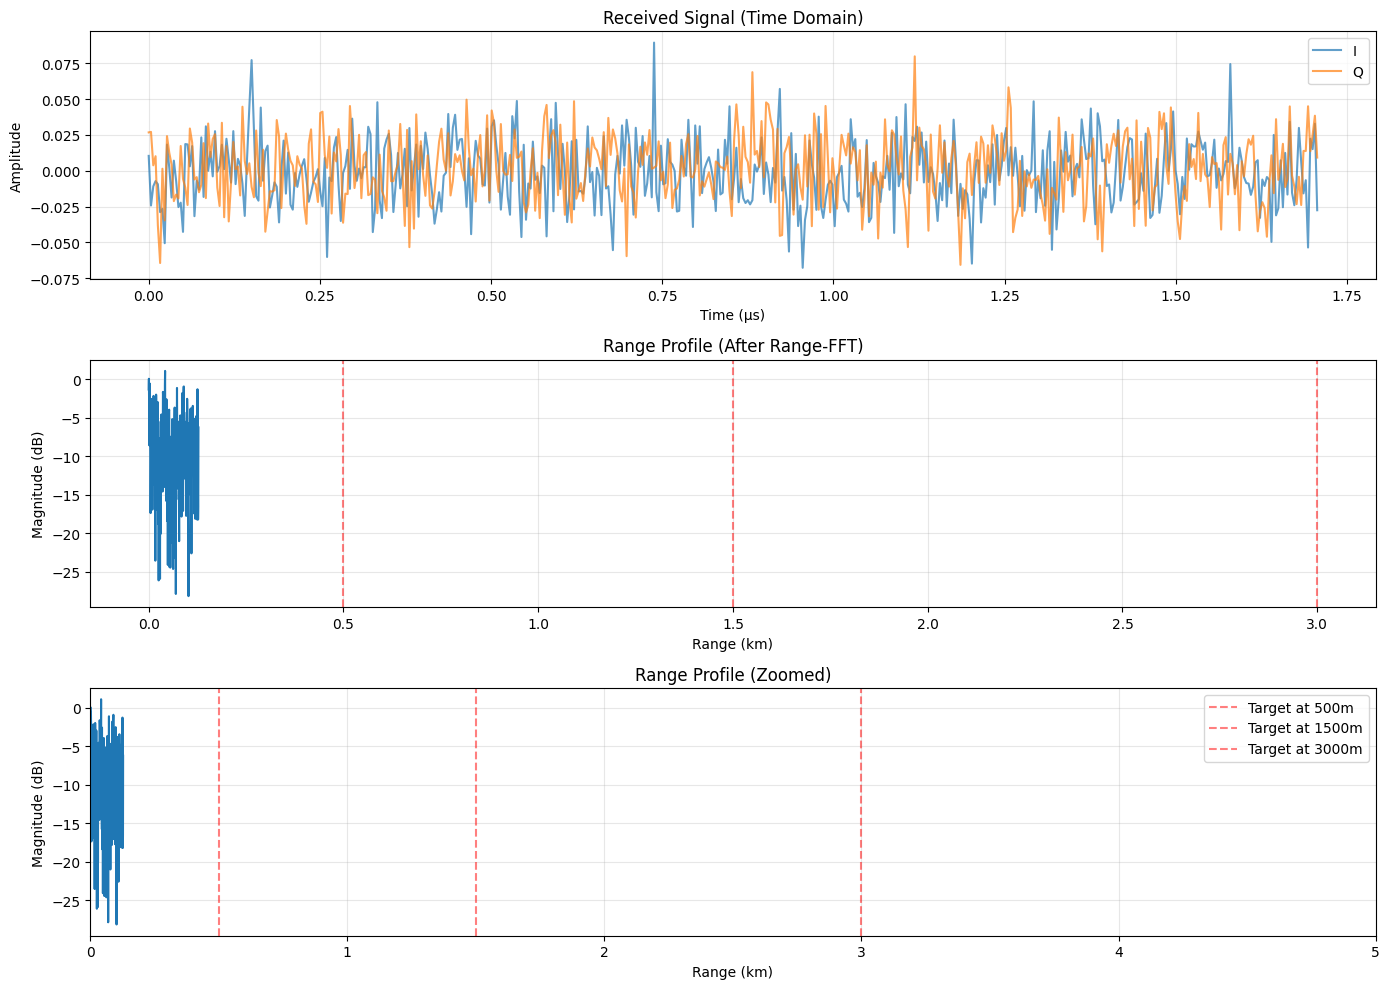

In [5]:
def generate_pulse_return(ranges, amplitudes, radar_params, num_samples=512):
    """
    Generate received signal from multiple targets

    Parameters:
    - ranges: array of target ranges (meters)
    - amplitudes: array of target amplitudes (relative)
    - radar_params: RadarParams object
    - num_samples: number of samples per pulse

    Returns:
    - signal: complex baseband signal (I/Q)
    - time_axis: time axis for samples
    - range_axis: corresponding range axis
    """
    # Sampling parameters
    f_s = 2 * radar_params.B  # Nyquist sampling
    T_sample = num_samples / f_s
    t = np.linspace(0, T_sample, num_samples)

    # Initialize signal
    signal = np.zeros(num_samples, dtype=complex)

    # Add each target's return
    for R, A in zip(ranges, amplitudes, strict=False):
        # Time delay for this range
        t_delay = 2 * R / radar_params.c
        # print("Time Delay (t_delay): ", t_delay)

        # Phase shift from range
        phase_shift = -4 * np.pi * R / radar_params.wavelength
        # print("Phase Shift from range (phase_shift): ", phase_shift, "\n")

        # Create pulse at correct time delay
        pulse_start = int(t_delay * f_s)
        pulse_length = int(radar_params.tau * f_s)

        if (pulse_start + pulse_length) < num_samples:
            # Add delayed pulse with phase shift
            signal[pulse_start:pulse_start + pulse_length] += A * np.exp(1j * phase_shift)

    # Add noise
    noise_power = 0.001
    noise = (np.random.randn(num_samples) + 1j * np.random.randn(num_samples)) * np.sqrt(noise_power/2)
    # print("\nNoise (noise): ", noise[:5], "\n")
    signal += noise
    # print("Signal with noise added (signal): ", signal[:5], "\n")

    # Range axis
    range_axis = (t * radar_params.c) / 2
    # print("Range Axis (range_axis): ", range_axis[:5], "\n")
    # print("Signal length: ", len(signal))
    return signal, t, range_axis

def range_fft_processing(signal, range_axis):
    """
    Process signal through Range-FFT

    Returns:
    - range_profile: magnitude in each range bin
    - range_axis: range for each bin
    """
    # Apply window to reduce sidelobes
    window = np.hamming(len(signal))
    signal_windowed = signal * window

    # FFT
    spectrum = fft(signal_windowed)

    # Magnitude (range profile)
    range_profile = np.abs(spectrum)

    # print(range_profile[:5])
    return range_profile, range_axis

# Example: Three targets at different ranges
ranges_targets = np.array([500, 1500, 3000])  # meters
amplitudes = np.array([1.0, 0.7, 0.5])  # relative strengths

signal_rx, time_axis, range_axis = generate_pulse_return(
    ranges_targets, amplitudes, radar
)

range_profile, _ = range_fft_processing(signal_rx, range_axis)

# Visualization
def plot_range_processing():
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))

    # Time domain signal (I/Q)
    axes[0].plot(time_axis * 1e6, signal_rx.real, label='I', alpha=0.7)
    axes[0].plot(time_axis * 1e6, signal_rx.imag, label='Q', alpha=0.7)
    axes[0].set_xlabel('Time (μs)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title('Received Signal (Time Domain)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Range profile (after FFT)
    axes[1].plot(range_axis[:len(range_axis)//2] / 1000,
                 20*np.log10(range_profile[:len(range_profile)//2] + 1e-10))
    axes[1].set_xlabel('Range (km)')
    axes[1].set_ylabel('Magnitude (dB)')
    axes[1].set_title('Range Profile (After Range-FFT)')
    axes[1].grid(True, alpha=0.3)
    for r in ranges_targets:
        axes[1].axvline(r/1000, color='red', linestyle='--', alpha=0.5)

    # Zoomed view around targets
    axes[2].plot(range_axis[:len(range_axis)//2] / 1000,
                 20*np.log10(range_profile[:len(range_profile)//2] + 1e-10))
    axes[2].set_xlabel('Range (km)')
    axes[2].set_ylabel('Magnitude (dB)')
    axes[2].set_title('Range Profile (Zoomed)')
    axes[2].set_xlim([0, 5])
    axes[2].grid(True, alpha=0.3)
    for r in ranges_targets:
        axes[2].axvline(r/1000, color='red', linestyle='--', alpha=0.5,
                       label=f'Target at {r}m')
    axes[2].legend()

    plt.tight_layout()
    # plt.savefig('/Users/amlanchatterjee/range_fft_demo.png', dpi=150, bbox_inches='tight')
    plt.show()

# Uncomment to run:
plot_range_processing()

---
# Next Steps

This covers the fundamentals. In the next notebook, we'll add:

1. **Doppler Processing** - FFT across multiple pulses
2. **Range-Doppler Maps** - The 2D FFT that gives you everything
3. **Moving targets** - See Doppler shift in action
4. **Micro-Doppler** - The magic that separates drones from birds

## Experiments to Try

Before moving on, modify the code above to explore:

1. **Change target ranges** - What happens when targets are very close together?
2. **Modify bandwidth** - How does this affect range resolution?
3. **Add more targets** - Can you resolve 5 targets? 10?
4. **Noise levels** - Increase noise_power - when do targets disappear?

## Key Takeaways

✅ FMCW uses beat frequency; Pulse-Doppler uses time bins  
✅ I/Q preserves amplitude AND phase (needed for Doppler)  
✅ Range-FFT converts time delays → range bins  
✅ Resolution depends on bandwidth, max range depends on PRF  
✅ Each radar parameter is a tradeoff!  

---

**Ready for Doppler processing?** Let me know and I'll create Part 2!